In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sb

import binary_formation_distribution_V8 as myscript
import NT_disk_Eqns_V1 as jscript
import pagn.constants as ct

from datetime import datetime, timedelta
from tqdm import tqdm

start = datetime.now()



In [8]:
c=693163

dir=f'EMRIs_Jupiter_2/c_{c}/SG/alpha_0.01/'

filename = f"EMRIs_Jupiter_2/c_{c}/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW.txt"

MBH, T = np.genfromtxt("SMBHmass_local_AGNlifetime_pairs.txt", unpack=True, skip_header=3)

In [9]:
def file_opener(filename):
    with open(filename) as f:
        lines = f.readlines()
    header_end = lines.index("Data:\n") + 1
    data = pd.read_csv(filename, delimiter=" ", skiprows=header_end)
    data.columns = [col.strip().replace(",", "") for col in data.columns]
    return data

def parse(value):
    try:
        if not '_' in value:
            return int(value)
        raise ValueError
    except ValueError:
        try:
            if not '_' in value:
                return float(value)
            raise ValueError
        except ValueError:
            try:
                if ':' in value:
                    parts = value.split(':')
                    if len(parts) == 3:
                        hours = int(parts[0])
                        minutes = int(parts[1])
                        seconds, microseconds = map(float, parts[2].split('.')) if '.' in parts[2] else (int(parts[2]), 0)
                        return timedelta(hours=hours, minutes=minutes, seconds=seconds, microseconds=int(microseconds))
                return datetime.strptime(value, "%y%m%d_%H%M")
            except ValueError:
                return value

def load_file_2(filename):
    params = {}
    data = {}
    
    with open(filename, 'r') as file:
        for line in file:
            if line=="Parameters:\n": continue
            elif line=="\n": continue
            elif line=="Data:\n": break
            else:
                line_splitted = line.strip().split()
                if len(line_splitted)==3: 
                    params[line_splitted[0]] = parse(line_splitted[2])
                else: 
                    params[line_splitted[0]] = []
                    for i in range(2, len(line_splitted)): 
                        params[line_splitted[0]].append(parse(line_splitted[i]))

        headers = file.readline().strip().replace(",", "").split()
        print(headers)
        data = {header: [] for header in headers}

        for line in file:
            values = line.strip().split()
            for i, header in enumerate(headers):
                data[header].append(parse(values[i]))
        
        for header in headers: data[header] = np.array(data[header])
    return params, data


In [10]:
data=file_opener(filename)

data2=load_file_2(filename)

['m1/Msun', 'r0/Rg', 't_gw/Myr', 't_migr/Myr', 'is_emri', 'Ng', 'R_final/Rg', 'lisa_radii/Rg', 't_lisa/Myr', 't_final/Myr', 'lisa_flag', 'total_flags']


In [11]:
print(data2)

({'version': 'V1', 'date_time': '251120_100413', 'comp_time': datetime.timedelta(seconds=805, microseconds=357922), 'disk_type': 'SG', 'torque_type': 'G23', 'alpha': 0.01, 'gen': '1g', 'N': 5000, 'M_smbh': -24.299, 'Spin': 0.9, 'T': 2.897e-15}, {'m1/Msun': array([15.49 , 18.71 , 18.22 , ..., 19.01 ,  6.915,  9.793]), 'r0/Rg': array([173.4  ,   6.867,   6.401, ...,   5.697, 121.4  ,  58.67 ]), 't_gw/Myr': array([1.778e-01, 3.624e-07, 2.809e-07, ..., 1.690e-07, 9.562e-02,
       3.689e-03]), 't_migr/Myr': array([3.732e-01, 8.221e-06, 7.731e-06, ..., 6.485e-06, 1.096e+00,
       2.951e-02]), 'is_emri': array(['False', 'True', 'True', ..., 'True', 'False', 'True'], dtype='<U5'), 'Ng': array([1, 1, 1, ..., 1, 1, 1]), 'R_final/Rg': array([371.   ,   2.321,   2.321, ...,   2.321,   2.321,   2.321]), 'lisa_radii/Rg': array([ 0. ,  0. ,  0. , ...,  0. , 16.1, 16.1]), 't_lisa/Myr': array([0.09143, 0.09143, 0.09143, ..., 0.09143, 1.721  , 0.08776]), 't_final/Myr': array([0.09143, 0.09143, 0.09143

In [12]:
with open(filename) as f:
    lines = f.readlines()

header_end = lines.index("Data:\n") + 1

for i in range (4, header_end-2):
    print(f'{lines[i].split(" = ")[0]}={lines[i].split(" = ")[1]}')

alpha=lines[6].split("= ",1)[1]
alpha=alpha.split('\n')[0]
print(float(alpha))

data = pd.read_csv(filename, delimiter=" ", skiprows=header_end)

data.columns = [col.strip().replace(",", "") for col in data.columns]
print(data.keys())

N=len(data["m1/Msun"])
print(f'Columns: {header_end}, Rows: {N}')


disk_type=SG

torque_type=G23

alpha=0.010

gen=1g

N=5000

M_smbh=-24.299

Spin=0.9

T=2.897e-15

0.01
Index(['m1/Msun', 'r0/Rg', 't_gw/Myr', 't_migr/Myr', 'is_emri', 'Ng',
       'R_final/Rg', 'lisa_radii/Rg', 't_lisa/Myr', 't_final/Myr', 'lisa_flag',
       'total_flags'],
      dtype='object')
Columns: 14, Rows: 5000


In [13]:

groups=data.groupby("total_flags", as_index=True)

# labels= "no inspiral or detection", "detected, no inspiral", "inspiral, no detection", "inspirals and detected"

# for k in range(0, groups.ngroups):
#     group=groups.get_group(k)["r0/Rg"]
#     print(labels[k], group)

N=len(data["m1/Msun"])

groups=data.groupby("total_flags", as_index=True)
labels= "no inspiral or detection", "detected, no inspiral", "inspiral, no detection", "inspirals and detected"
labels= ["no inspiral, no mig w/in $T_{disc}$, no detection", 
"inspiral, no mig w/in $T_{disc}$, no detection", 
"no inspiral, mig w/in $T_{disc}$, no detection", 
"inspiral, mig w/in $T_{disc}$, no detection", 
"no inspiral, no mig w/in $T_{disc}$, detection", 
" inspiral, no mig w/in $T_{disc}$, detection", 
"no inspiral, mig w/in $T_{disc}$, detection", 
"inspiral, mig w/in $T_{disc}$, detection"]

Mbh=MBH[c]
print(f'{MBH[c]:.1e}')

N=len(data["m1/Msun"])

print(N)

power=np.log10(Mbh)


1.0e+06
5000


In [14]:
for group in groups:
    print(group)

(0,       m1/Msun  r0/Rg  t_gw/Myr  t_migr/Myr  is_emri  Ng  R_final/Rg  \
0      15.490  173.4    0.1778      0.3732    False   1       371.0   
4      13.760  148.5    0.1079      1.4950    False   1       222.1   
12      8.596  274.4    2.0100      0.2140    False   1       371.0   
13      8.626  163.7    0.2537      0.9422    False   1       253.5   
14     10.230  251.1    1.1850      0.1900    False   1       371.2   
...       ...    ...       ...         ...      ...  ..         ...   
4957   17.940  313.2    1.6340      0.1218    False   1       371.2   
4974   18.660  222.7    0.4019      0.1283    False   1       371.3   
4982   17.620  174.4    0.1601      0.3178    False   1       371.3   
4983   18.810  254.6    0.6808      0.1019    False   1       371.4   
4984    7.120  265.7    2.1350      0.2605    False   1       370.3   

      lisa_radii/Rg  t_lisa/Myr  t_final/Myr  lisa_flag  total_flags  
0               0.0     0.09143      0.09143          0            0  
4

0, no inspiral, no mig w/in $T_{disc}$, no detection
1, inspiral, no mig w/in $T_{disc}$, no detection
2, no inspiral, mig w/in $T_{disc}$, no detection
3, inspiral, mig w/in $T_{disc}$, no detection
4, no inspiral, no mig w/in $T_{disc}$, detection
5,  inspiral, no mig w/in $T_{disc}$, detection
6, no inspiral, mig w/in $T_{disc}$, detection
7, inspiral, mig w/in $T_{disc}$, detection


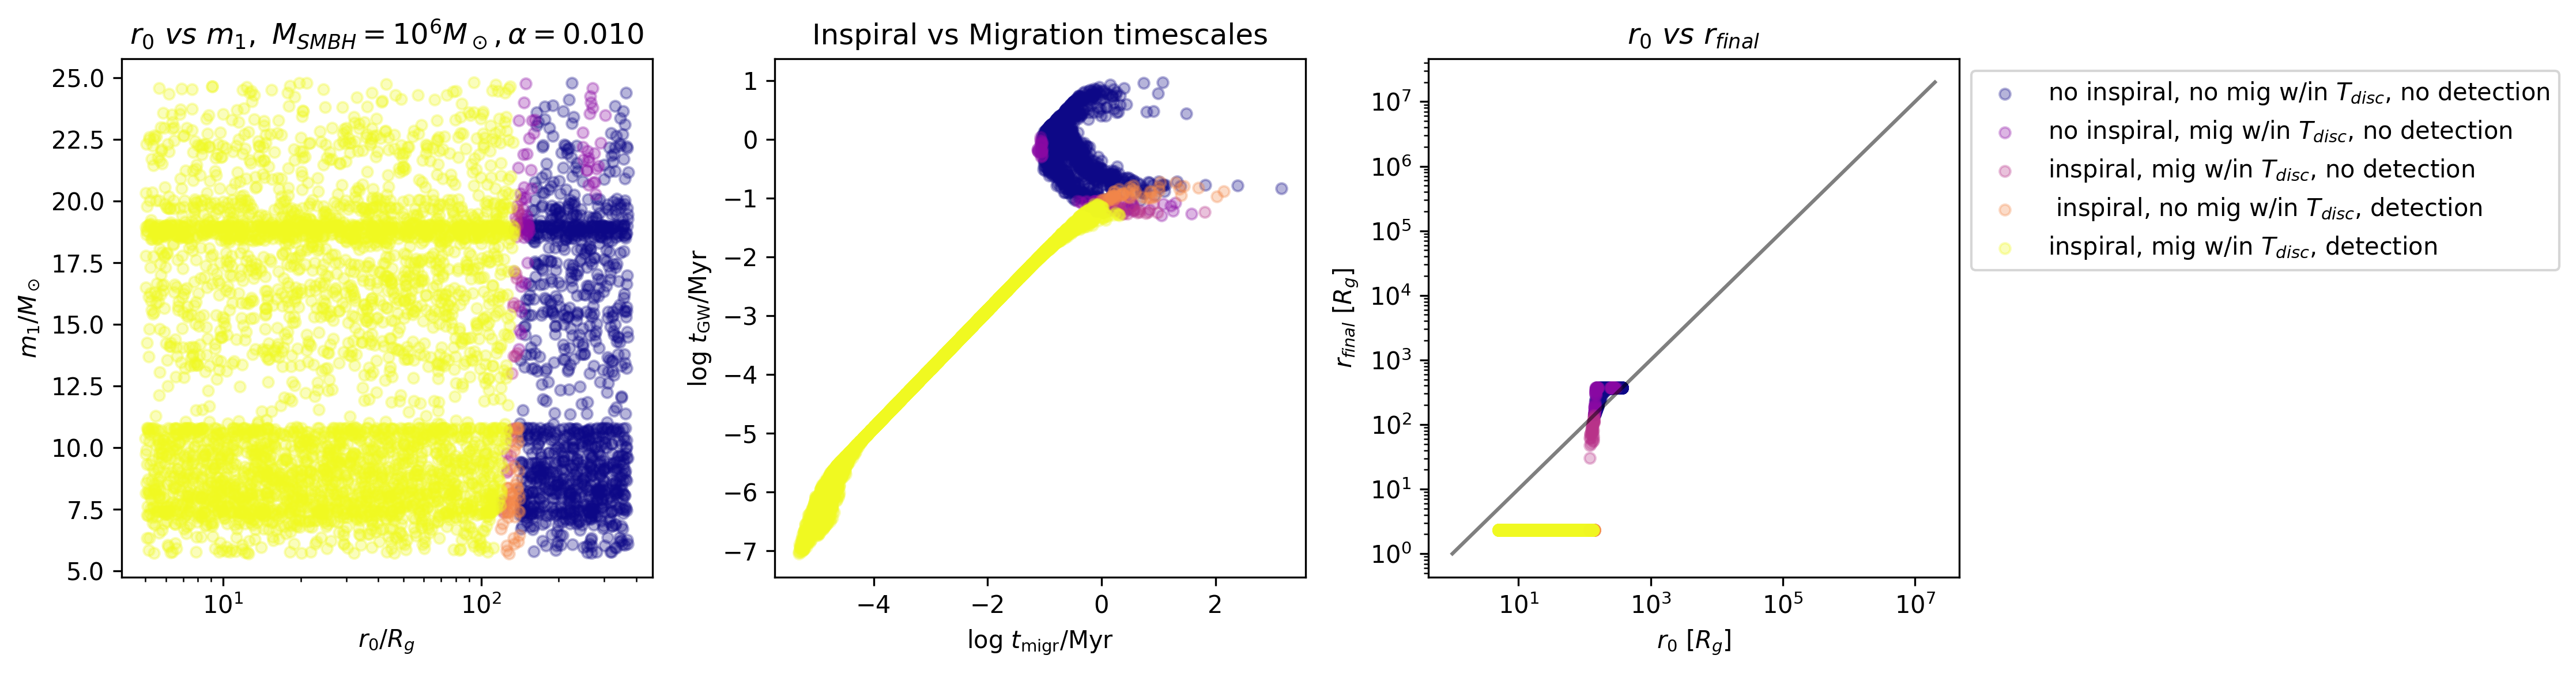

In [ ]:
colour='plasma'
# colour='rainbow_r'

cmap = plt.colormaps[colour]
colors_map = {0: cmap(0.), 1: cmap(1.0/7), 2: cmap(2.0/7), 3: cmap(3.0/7), 4: cmap(4.0/7), 5: cmap(5.0/7), 6: cmap(6.0/7), 7: cmap(7.0/7)}

# colors_map = {0: 'r', 1: 'orange', 2: 'y', 3: 'green', 4: 'c', 5: 'b', 6: 'rebeccapurple', 7: 'm'}


fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
i=0

for k in range(0, 8):
    print(f'{k}, {labels[k]}')
    try: 
        axs[i].scatter(groups.get_group(k)["r0/Rg"], groups.get_group(k)["m1/Msun"], color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass
axs[i].set_xlabel(r'$r_{\rm 0} / R_g$')
axs[i].set_xscale('log')
# axs[i].set_xlim(3, 5e2)
axs[i].set_ylabel(r'$m_1 / M_\odot$')
axs[i].set_title('$r_0~vs~m_1,~M_{SMBH}=$'f'$10^{power:.0f}$'r'$M_\odot, \alpha=$'f'{alpha}',
    )

i=1
t_migr = np.log10(data["t_migr/Myr"])
t_gw = np.log10(data["t_gw/Myr"])

for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups.get_group(k)["t_migr/Myr"]), np.log10(groups.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title('Inspiral vs Migration timescales')


i=2
for k in range(0, 8):
    try: 
        axs[i].scatter(groups.get_group(k)["r0/Rg"], groups.get_group(k)["R_final/Rg"], color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

x = np.linspace(1, 2e7, 100)
axs[i].plot(x, x, c="black", alpha=0.5)

axs[i].set_xlabel(r'$r_0$ [$R_g$]')
axs[i].set_xlim(3, 9e3)
axs[i].set_ylim(1, 9e3)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].set_ylabel(r'$r_{final}$ [$R_g$]')
axs[i].set_title('$r_0~vs~r_{final}$')
# axs[i].legend()
axs[i].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig(f'{dir}/summary_{N}_SMBH_1e{power:.0f}.pdf')
plt.show()

In [71]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
# i=0

# for k in range(0, 8):
#     print(f'{k}, {labels[k]}')
#     try: 
#         axs[i].scatter(groups.get_group(k)["logMBH/Msun"], groups.get_group(k)["m1/Msun"], color=colors_map[k],
#                    label=labels[k],
#                    s=20, alpha=0.3, edgecolor="k")
#     except KeyError:
#         pass
# # sc1 = axs[i].scatter(data["logMBH/Msun"], data["m1/Msun"], c=data['total_flags'], cmap=colour, alpha=0.6, edgecolor='k', s=20)
# axs[i].set_xlabel(r'$\log_{10} M_{\rm SMBH} / M_\odot$')
# axs[i].set_ylabel(r'$m_1 / M_\odot$')
# axs[i].set_title('Stellar-mass BH vs SMBH mass')

# i=1
# t_migr = np.log10(data["t_migr/Myr"])
# t_gw = np.log10(data["t_gw/Myr"])

# for k in range(0, 8):
#     try: 
#         axs[i].scatter(np.log10(groups.get_group(k)["t_migr/Myr"]), np.log10(groups.get_group(k)["t_gw/Myr"]), color=colors_map[k],
#                    label=labels[k],
#                    s=20, alpha=0.3, edgecolor="k")
#     except KeyError:
#         pass

# # sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)
# # axs[i].plot([min(t_gw.min(), t_migr.min()), max(t_gw.max(), t_migr.max())],
# #             [min(t_gw.min(), t_migr.min()), max(t_gw.max(), t_migr.max())],
#             # 'k--', label=r'$t_{\rm GW} = t_{\rm migr}$')

# axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
# axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
# axs[i].set_title('Inspiral vs Migration timescales')

# i=2
# for k in range(0, 8):
#     try: 
#         axs[i].scatter(groups.get_group(k)["r0/Rg"], groups.get_group(k)["chi_eff"], color=colors_map[k],
#                    label=labels[k],
#                    s=20, alpha=0.3, edgecolor="k")
#     except KeyError:
#         pass
# axs[i].set_xlabel(r'$a$ [$R_g$]')
# axs[i].set_xscale('log')
# axs[i].set_ylabel(r'$\chi_{\rm eff}$')
# axs[i].set_title('Initial SMA vs Effective Spin')
# # axs[i].legend()
# axs[i].legend(bbox_to_anchor=(1,1))

# plt.tight_layout()
# plt.savefig(f'{dir}/summary_{N}_SMBH_{Mbh}.pdf')
# plt.show()

In [72]:
# Function to make 1 scatter + marginal histograms
def plot_with_marginals(fig, data, x, y, is_emri, xlabel, ylabel, title, logx=False, logy=False):
    g = sb.jointplot(
        data=data,
        x=x, y=y,
        hue=is_emri,
        palette=colors_map,
        alpha=0.5
    )

    g.figure.suptitle(title, y=1.00)
    g.set_axis_labels(xlabel, ylabel)

    if logx:
        g.ax_joint.set_xscale('log')
        g.ax_marg_x.set_xscale('log')
    if logy:
        g.ax_joint.set_yscale('log')
        g.ax_marg_y.set_yscale('log')




8.000000088335895


<Figure size 600x600 with 0 Axes>

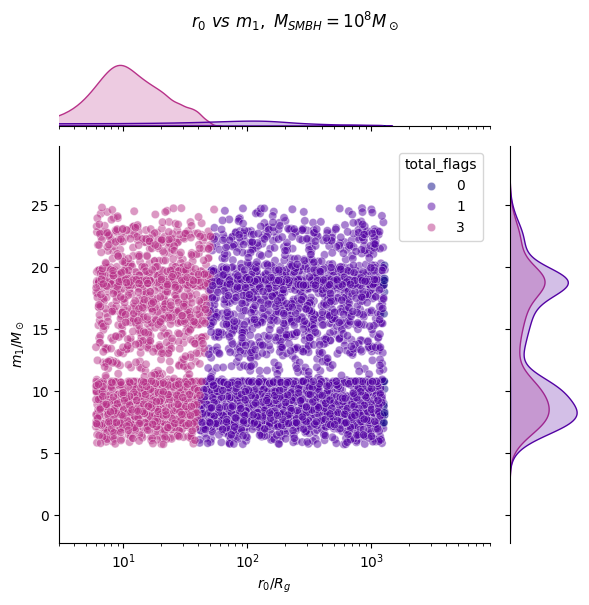

In [73]:
fig = plt.figure(figsize=(6, 6))

power=np.log10(Mbh)
print(power)

# Plot 1: m1 vs logMBH
plot_with_marginals(
    fig, data,
    x="r0/Rg",
    y="m1/Msun",
    is_emri="total_flags",
    xlabel=r'$r_{\rm 0} / R_g$',
    ylabel=r'$m_1 / M_\odot$',
    title='$r_0~vs~m_1,~M_{SMBH}=$'f'$10^{power:.0f}$'r'$M_\odot$',
    logx=True
)

plt.xlim(3, 9e3)
plt.tight_layout()

plt.savefig(f'{dir}/r0_{N}_SBH_{Mbh:.1e}.pdf')
plt.show()

<Figure size 600x600 with 0 Axes>

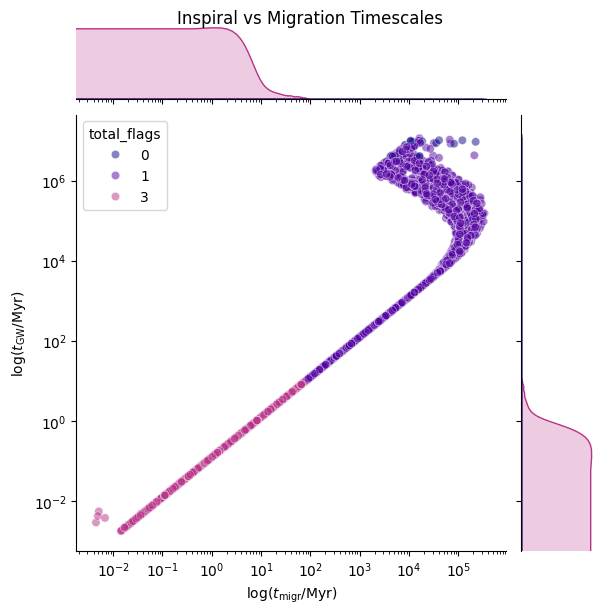

In [74]:
fig = plt.figure(figsize=(6, 6))

# Plot 2: log t_migr vs log t_gw
plot_with_marginals(
    fig, data,
    x="t_migr/Myr",
    y="t_gw/Myr",
    is_emri="total_flags",
    xlabel=r'$\log (t_{\rm migr} / \mathrm{Myr})$',
    ylabel=r'$\log (t_{\rm GW} / \mathrm{Myr})$',
    title='Inspiral vs Migration Timescales',
    logx=True,
    logy=True
)


fig.tight_layout()
plt.savefig(f'{dir}/timescales_{N}_SMBH_{Mbh:.1e}.pdf')
plt.show()

<Figure size 600x600 with 0 Axes>

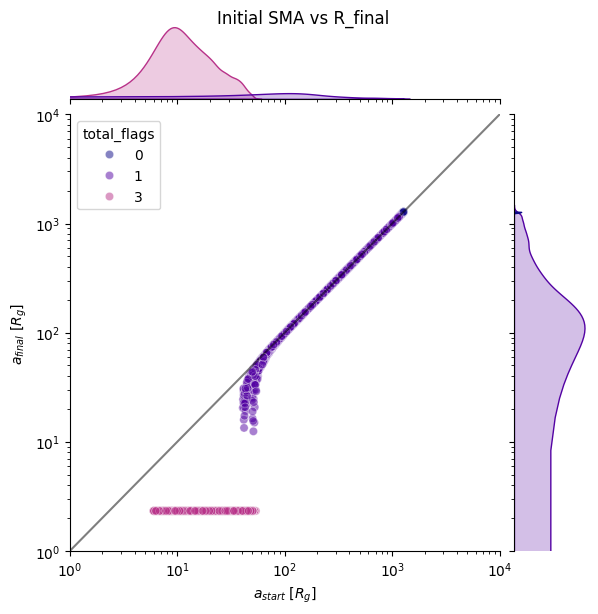

In [75]:
fig = plt.figure(figsize=(6, 6))

# # Plot 3: r0 vs chi_eff
# plot_with_marginals(
#     fig, data,
#     x="r0/Rg",
#     y="lisa_radii/Rg",
#     is_emri="final_flag",
#     xlabel=r'$a_{start}$ [$R_g$]',
#     ylabel=r'$a_{lisa}$ [$R_g$]',
#     title='Initial SMA vs R_final',
#     logx=True,
#     logy=True
# )

plot_with_marginals(
    fig, data,
    x="r0/Rg",
    y="R_final/Rg",
    is_emri="total_flags",
    xlabel=r'$a_{start}$ [$R_g$]',
    ylabel=r'$a_{final}$ [$R_g$]',
    title='Initial SMA vs R_final',
    logx=True,
    logy=True
)

x = np.linspace(1, 1e5, 100)
plt.plot(x, x, c="black", alpha=0.5)

plt.xlim(1, 1e4)
plt.ylim(1, 1e4)

fig.tight_layout()
plt.savefig(f'{dir}/sma_final_{N}_SMBH_{Mbh:.1e}.pdf')
plt.show()

In [25]:
# Function to make 1 scatter + marginal histograms
def plot_with_marginals(fig, data, x, y, is_emri, xlabel, ylabel, title, logx=False, logy=False):
    g = sb.jointplot(
        data=data,
        x=x, y=y,
        hue=is_emri,
        palette=colors_map,
        alpha=0.5
    )

    g.figure.suptitle(title, y=1.02)
    g.set_axis_labels(xlabel, ylabel)

    if logx:
        g.ax_joint.set_xscale('log')
        g.ax_marg_x.set_xscale('log')
    if logy:
        g.ax_joint.set_yscale('log')
        g.ax_marg_y.set_yscale('log')


<Figure size 600x600 with 0 Axes>

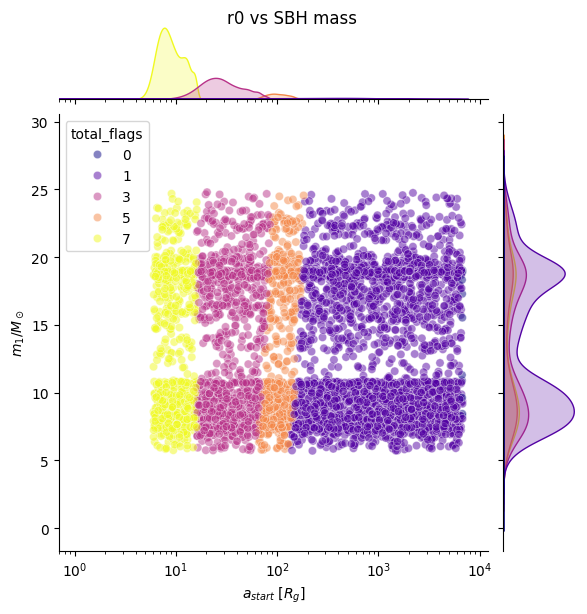

In [58]:
fig = plt.figure(figsize=(6, 6))

# Plot 3: r0 vs chi_eff
plot_with_marginals(
    fig, data,
    x="r0/Rg",
    y="m1/Msun",
    is_emri="total_flags",
    xlabel=r'$a_{start}$ [$R_g$]',
    ylabel=r'$m_1 / M_\odot$',
    title='r0 vs SBH mass',
    logx=True,
    logy=False
)

fig.tight_layout()
plt.savefig(f'{dir}/sma_sbh_{N}_SMBH_{Mbh:.1e}.pdf')
plt.show()

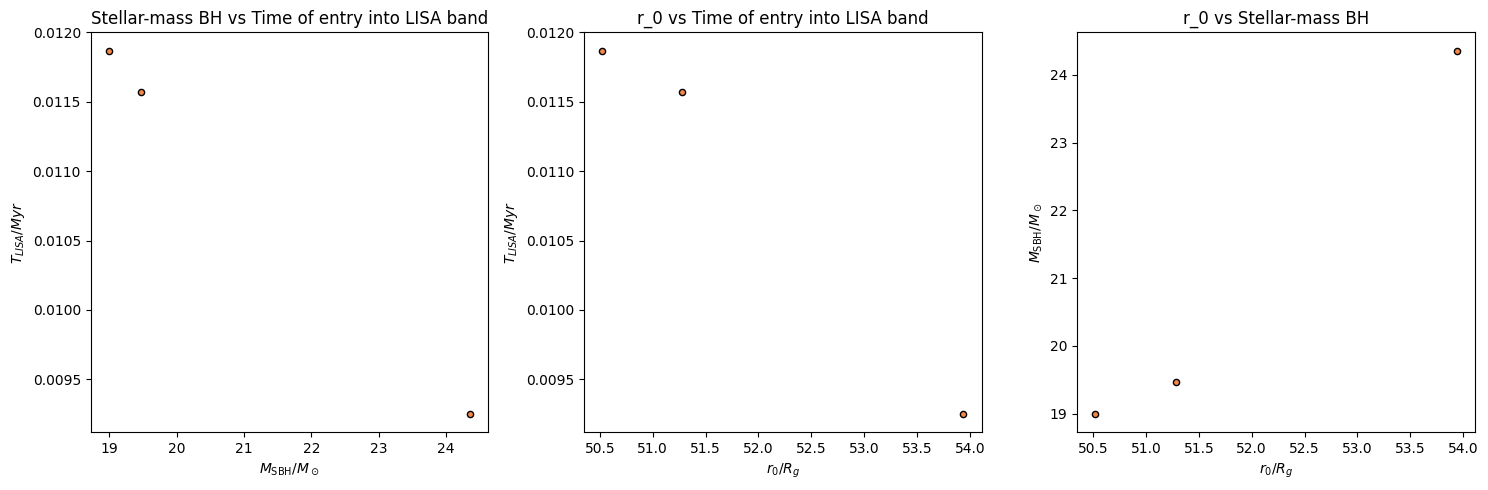

In [45]:
dried_emri_group=groups.get_group(5)['m1/Msun']
dried_emri_group1=groups.get_group(5)['t_lisa/Myr']
dried_emri_group2=groups.get_group(5)['r0/Rg']

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

i=0
axs[i].scatter(dried_emri_group, dried_emri_group1, color=colors_map[5], s=20, edgecolor="k")

axs[i].set_xlabel(r'$M_{\rm SBH} / M_\odot$')
axs[i].set_ylabel(r'$T_{LISA} / Myr$')
axs[i].set_title('Stellar-mass BH vs Time of entry into LISA band')

i=1
axs[i].scatter(dried_emri_group2, dried_emri_group1, color=colors_map[5], s=20, edgecolor="k")

axs[i].set_xlabel(r'$r_0 / R_g$')
axs[i].set_ylabel(r'$T_{LISA} / Myr$')
axs[i].set_title('r_0 vs Time of entry into LISA band')

i=2
axs[i].scatter(dried_emri_group2, dried_emri_group, color=colors_map[5], s=20, edgecolor="k")

axs[i].set_xlabel(r'$r_0 / R_g$')
axs[i].set_ylabel(r'$M_{\rm SBH} / M_\odot$')
axs[i].set_title('r_0 vs Stellar-mass BH')


plt.tight_layout()
plt.savefig(f'{dir}/summary_{N}_SMBH_{Mbh:.1e}_dried_EMRIs.pdf')
plt.show()



In [3]:
MBH, T = np.genfromtxt("SMBHmass_local_AGNlifetime_pairs.txt", unpack=True, skip_header=3)

In [74]:
Mbh_4=file_opener(filename = "EMRIs_Jupiter_2/c_663176/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW.txt")
Mbh_5=file_opener(filename = "EMRIs_Jupiter_2/c_121606/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW.txt")
Mbh_6=file_opener(filename = "EMRIs_Jupiter_2/c_693163/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW_2.txt")
Mbh_7=file_opener(filename = "EMRIs_Jupiter_2/c_392643/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW_2.txt")
Mbh_8=file_opener(filename = "EMRIs_Jupiter_2/c_17205/SG/alpha_0.01/EMRIs_G23_1g_5000_events_with_GW_2.txt")

In [75]:
groups4=Mbh_4.groupby("total_flags", as_index=True)
groups5=Mbh_5.groupby("total_flags", as_index=True)
groups6=Mbh_6.groupby("total_flags", as_index=True)
groups7=Mbh_7.groupby("total_flags", as_index=True)
groups8=Mbh_8.groupby("total_flags", as_index=True)


labels= "no inspiral or detection", "detected, no inspiral", "inspiral, no detection", "inspirals and detected"
labels= ["no inspiral, no mig w/in T_disc, no detection", 
"inspiral, no mig w/in T_disc, no detection", 
"no inspiral, mig w/in T_disc, no detection", 
"inspiral, mig w/in T_disc, no detection", 
"no inspiral, no mig w/in T_disc, detection", 
" inspiral, no mig w/in T_disc, detection", 
"no inspiral, mig w/in T_disc, detection", 
"inspiral, mig w/in T_disc, detection"]

colour='plasma'

cmap = plt.colormaps[colour]
colors_map = {0: cmap(0.), 1: cmap(1.0/7), 2: cmap(2.0/7), 3: cmap(3.0/7), 4: cmap(4.0/7), 5: cmap(5.0/7), 6: cmap(6.0/7), 7: cmap(7.0/7)}


<function matplotlib.pyplot.show(close=None, block=None)>

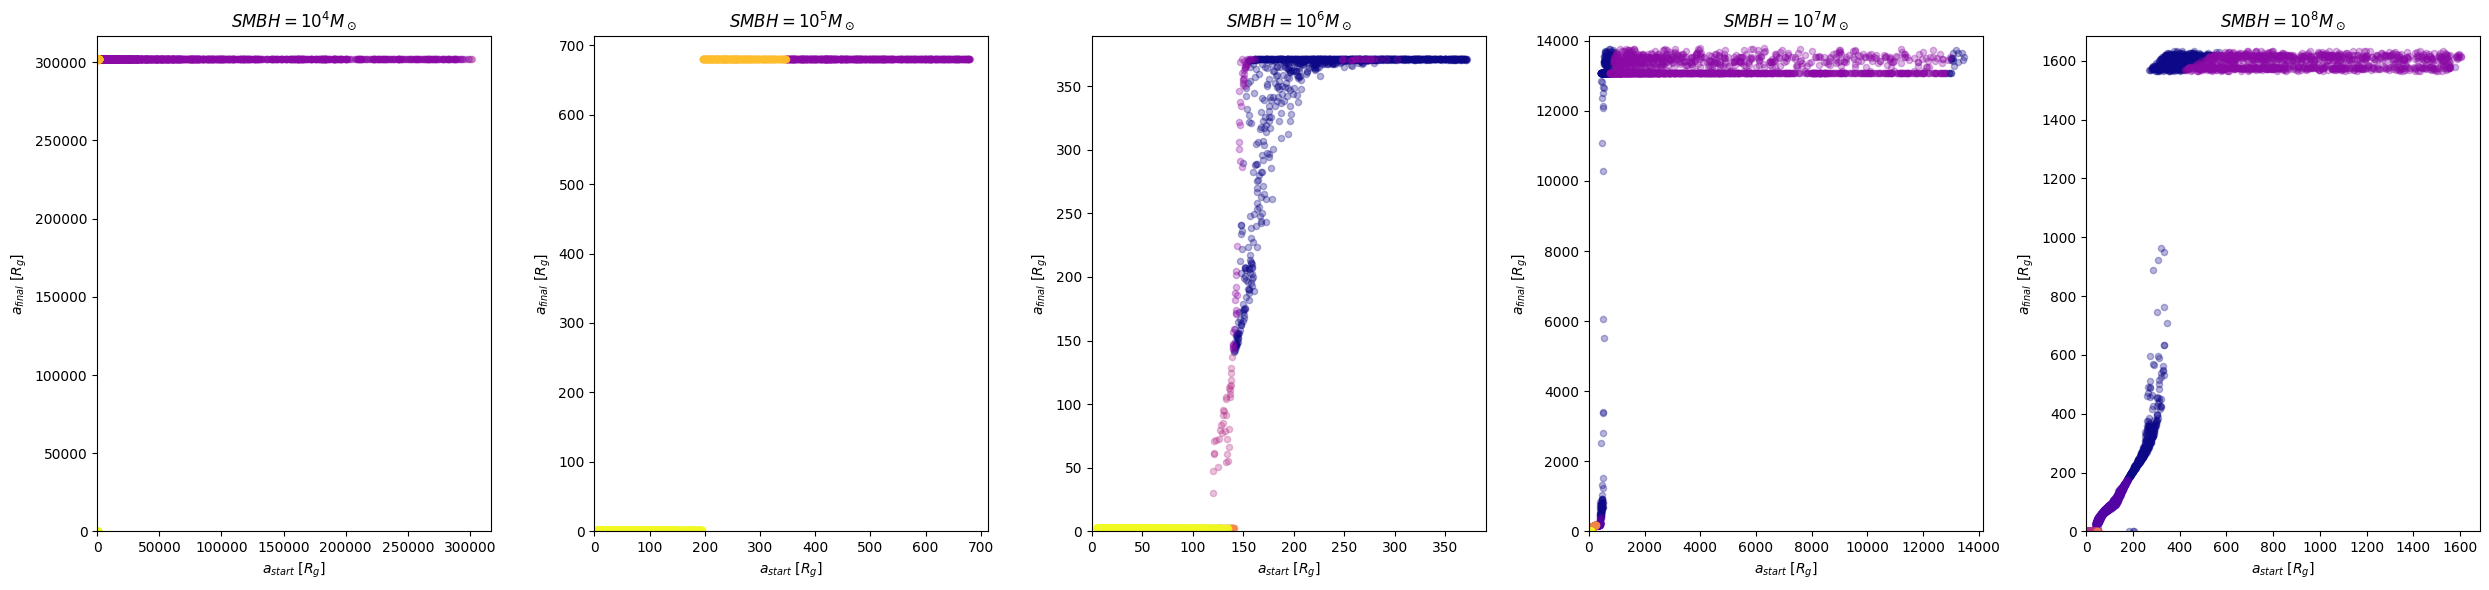

In [73]:
x="r0/Rg",
y="R_final/Rg"


groups=groups4, groups5, groups6, groups7, groups8
titles=r'$SMBH = 10^4 {M_\odot}$', r'$SMBH = 10^5 {M_\odot}$', r'$SMBH = 10^6 {M_\odot}$', r'$SMBH = 10^7 {M_\odot}$', r'$SMBH = 10^8 {M_\odot}$'

fig, axs = plt.subplots(1, 5, figsize=(25, 6), dpi=100)

for i in range(0, len(groups)):
    maxes=[]
    for k in range(0, 8):
        try: 
            axs[i].scatter((groups[i].get_group(k)["r0/Rg"]),(groups[i].get_group(k)["R_final/Rg"]), color=colors_map[k],
                    label=labels[k],
                    s=20, alpha=0.3)
            max=np.max((groups[i].get_group(k)["r0/Rg"]))
            maxes.append(max)
        except KeyError:
            pass
    new_max=np.max(maxes)

    axs[i].set_xlabel(r'$a_{start}$ [$R_g$]')
    axs[i].set_ylabel(r'$a_{final}$ [$R_g$]')
    axs[i].set_title(titles[i])
    axs[i].set_xlim(0, 1.05*new_max)
    axs[i].set_ylim(0, 1.05*new_max)

plt.tight_layout()
# plt.savefig(f'EMRIs_Jupiter_2/rs_multiple_SMBHs_nonlog.pdf')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

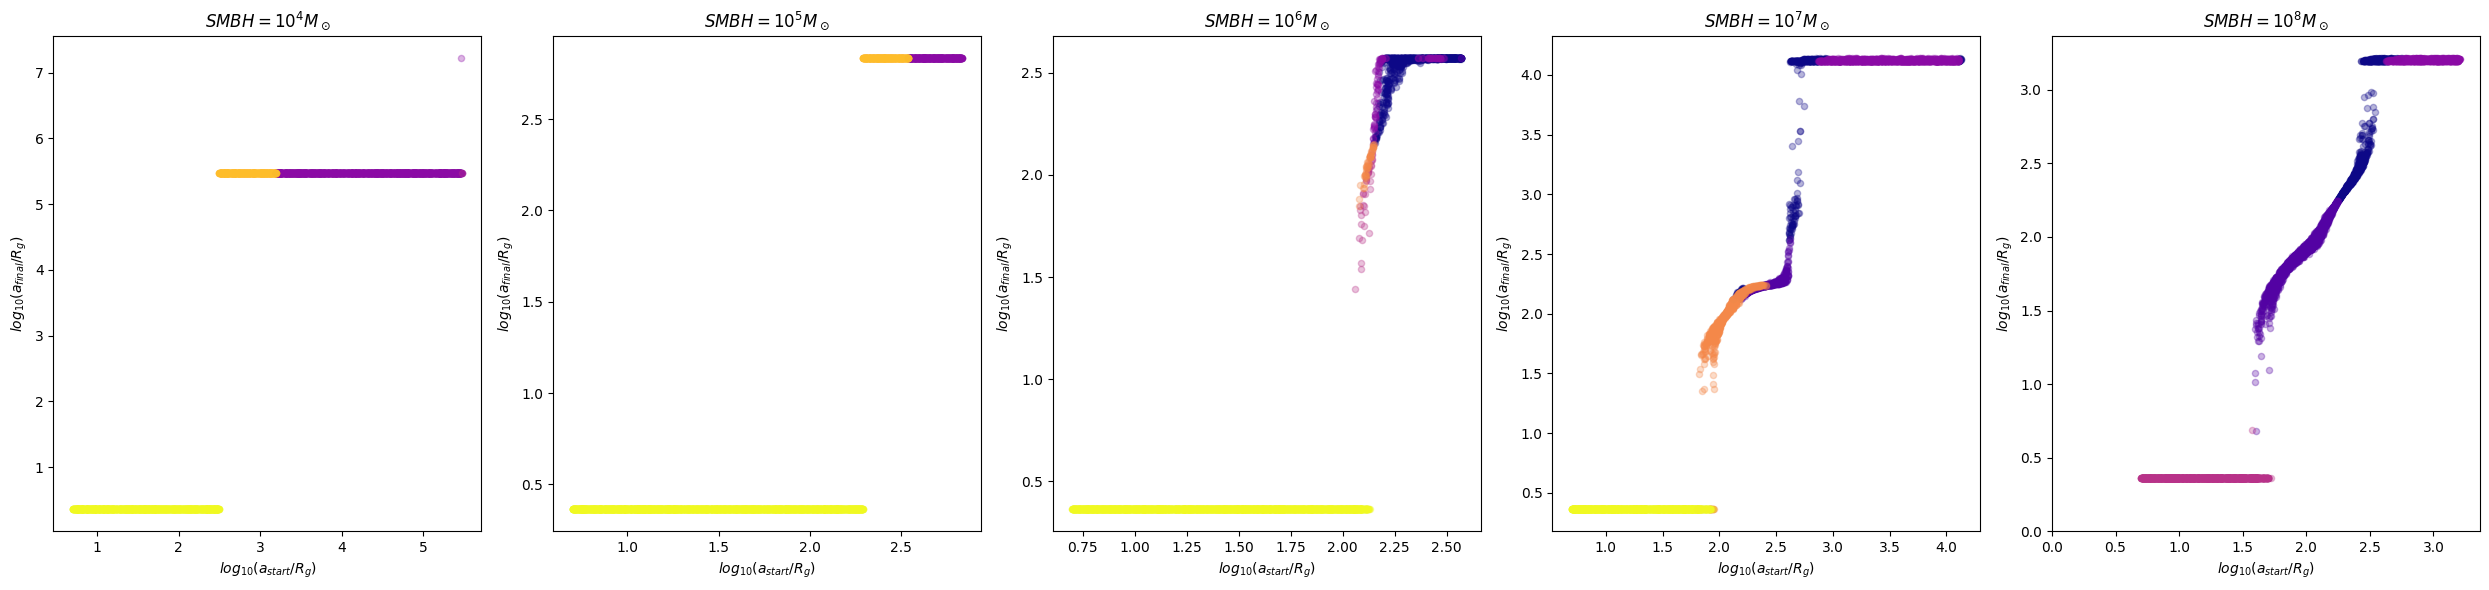

In [76]:
x="r0/Rg",
y="R_final/Rg"


groups=groups4, groups5, groups6, groups7, groups8
titles=r'$SMBH = 10^4 {M_\odot}$', r'$SMBH = 10^5 {M_\odot}$', r'$SMBH = 10^6 {M_\odot}$', r'$SMBH = 10^7 {M_\odot}$', r'$SMBH = 10^8 {M_\odot}$'

fig, axs = plt.subplots(1, 5, figsize=(25, 6), dpi=100)

for i in range(0, len(groups)):
    maxes=[]
    for k in range(0, 8):
        try: 
            axs[i].scatter(np.log10(groups[i].get_group(k)["r0/Rg"]),np.log10(groups[i].get_group(k)["R_final/Rg"]), color=colors_map[k],
                    label=labels[k],
                    s=20, alpha=0.3)
            max=np.max(np.log10(groups[i].get_group(k)["r0/Rg"]))
            maxes.append(max)
        except KeyError:
            pass
        
    new_max=np.max(maxes)

    axs[i].set_xlabel(r'$log_{10}(a_{start}/R_g$)')
    axs[i].set_ylabel(r'$log_{10}(a_{final}/R_g$)')
    axs[i].set_title(titles[i])

axs[i].set_xlim(0, 1.05*new_max)
axs[i].set_ylim(0, 1.05*new_max)

plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/rs_multiple_SMBHs_log.pdf')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

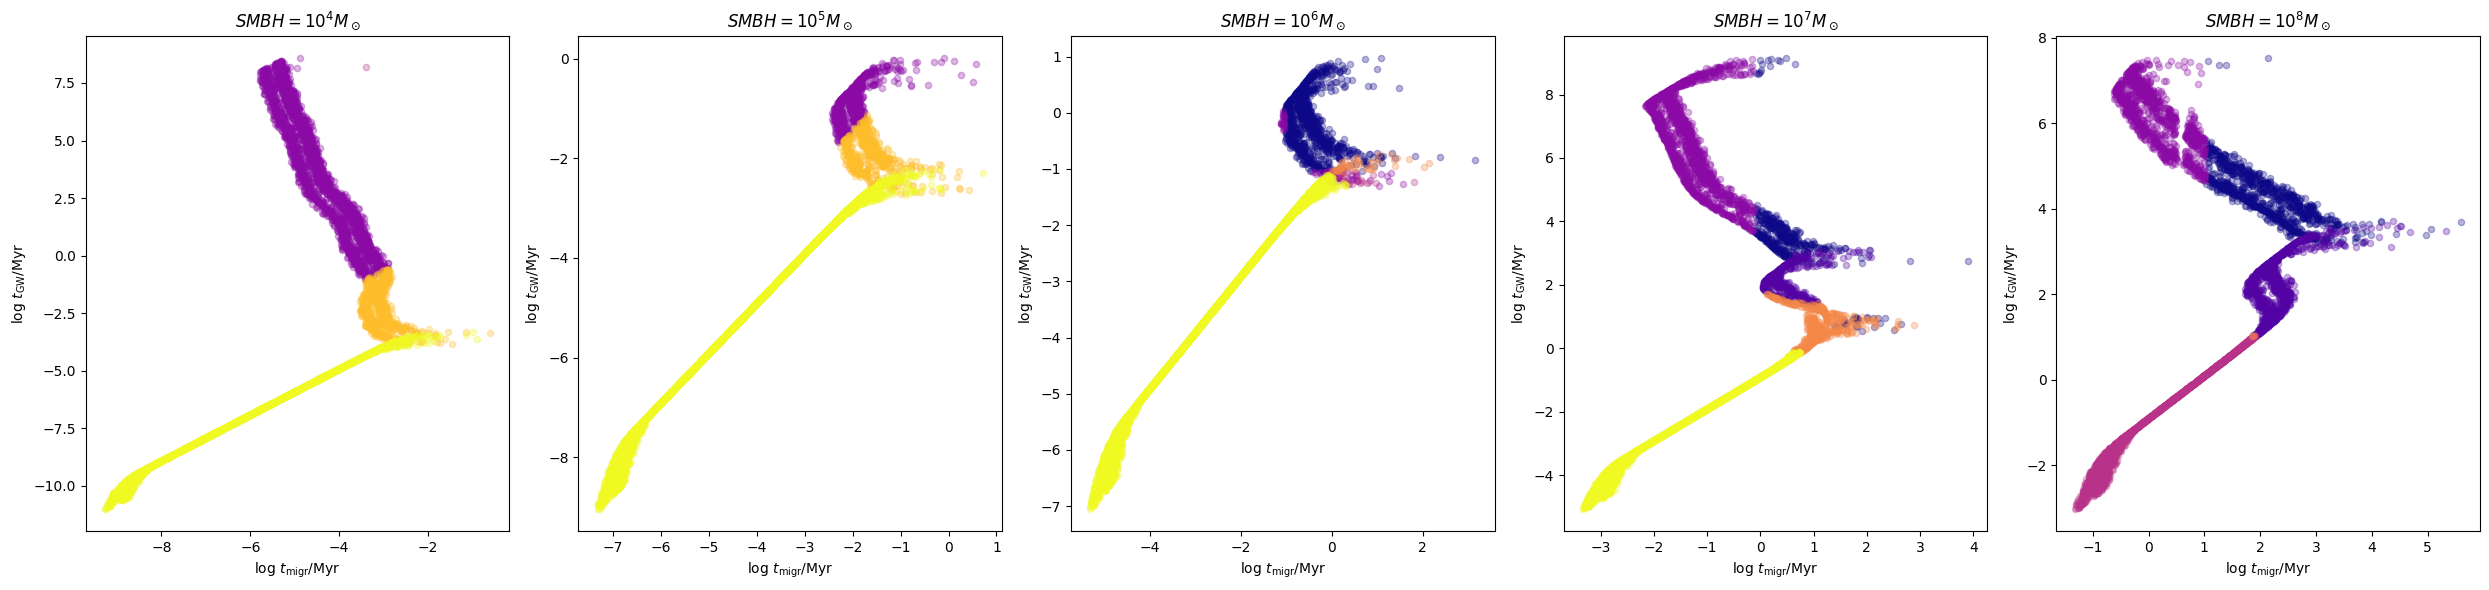

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(25, 6), dpi=100)

i=0

for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups4.get_group(k)["t_migr/Myr"]), np.log10(groups4.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass


axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title(r'$SMBH = 10^4 {M_\odot}$')

i=1

for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups5.get_group(k)["t_migr/Myr"]), np.log10(groups5.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

# sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)

axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title(r'$SMBH = 10^5 {M_\odot}$')
# axs[i].set_xlim(1, 3e4)
# axs[i].set_ylim(1, 3e4)

i=2
# t_migr = np.log10(data["t_migr/Myr"])
# t_gw = np.log10(data["t_gw/Myr"])

for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups6.get_group(k)["t_migr/Myr"]), np.log10(groups6.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

# sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)

axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title(r'$SMBH = 10^6 {M_\odot}$')

# axs[i].set_xlim(1, 3e4)
# axs[i].set_ylim(1, 3e4)

i=3
for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups7.get_group(k)["t_migr/Myr"]), np.log10(groups7.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

# sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)
axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title(r'$SMBH = 10^7 {M_\odot}$')
# axs[i].set_xlim(1, 3e3)
# axs[i].set_ylim(1, 3e3)
# axs[i].legend()

i=4
for k in range(0, 8):
    try: 
        axs[i].scatter(np.log10(groups8.get_group(k)["t_migr/Myr"]), np.log10(groups8.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

# sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)

axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title(r'$SMBH = 10^8 {M_\odot}$')
# axs[i].set_xlim(0, 4)
# axs[i].set_ylim(0, 4)

plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/T_multiple_SMBHs_3.pdf')

plt.show

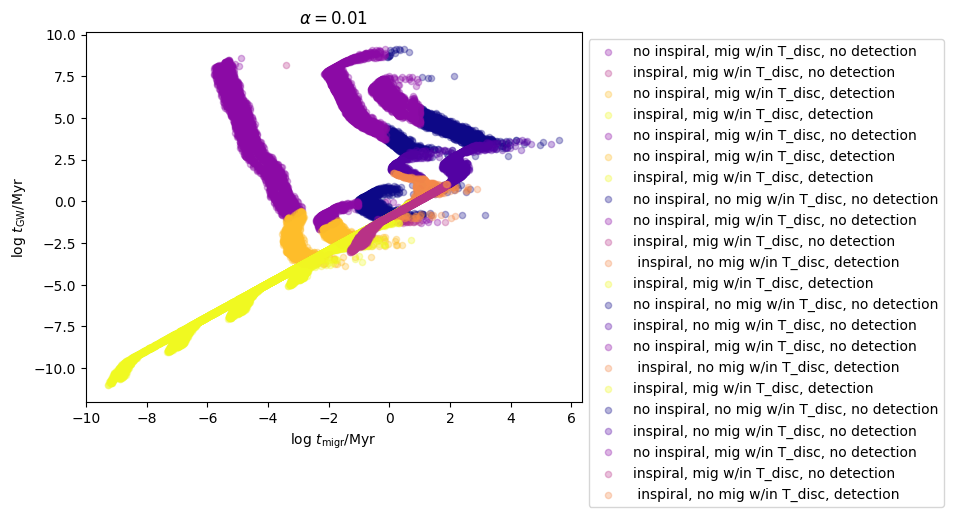

<Figure size 400x400 with 0 Axes>

In [32]:


for k in range(0, 8):
    try: 
        plt.scatter(np.log10(groups4.get_group(k)["t_migr/Myr"]), np.log10(groups4.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass


for k in range(0, 8):
    try: 
        plt.scatter(np.log10(groups5.get_group(k)["t_migr/Myr"]), np.log10(groups5.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

plt.xlabel(r'log $t_{\rm migr}$/Myr')
plt.ylabel(r'log $t_{\rm GW}$/Myr')
plt.title(r'$SMBH = 10^5 {M_\odot}$')

for k in range(0, 8):
    try: 
        plt.scatter(np.log10(groups6.get_group(k)["t_migr/Myr"]), np.log10(groups6.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

plt.xlabel(r'log $t_{\rm migr}$/Myr')
plt.ylabel(r'log $t_{\rm GW}$/Myr')
plt.title(r'$SMBH = 10^6 {M_\odot}$')

for k in range(0, 8):
    try: 
        plt.scatter(np.log10(groups7.get_group(k)["t_migr/Myr"]), np.log10(groups7.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

plt.xlabel(r'log $t_{\rm migr}$/Myr')
plt.ylabel(r'log $t_{\rm GW}$/Myr')
plt.title(r'$SMBH = 10^7 {M_\odot}$')

for k in range(0, 8):
    try: 
        plt.scatter(np.log10(groups8.get_group(k)["t_migr/Myr"]), np.log10(groups8.get_group(k)["t_gw/Myr"]), color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.3)
    except KeyError:
        pass

plt.legend(bbox_to_anchor=(1,1))
# sc2 = axs[i].scatter(t_migr, t_gw, c=data["total_flags"], cmap=colour, alpha=0.6, edgecolor='k', s=20)

plt.xlabel(r'log $t_{\rm migr}$/Myr')
plt.ylabel(r'log $t_{\rm GW}$/Myr')
plt.title(r'$\alpha = 0.01$')

plt.figure(figsize=(4, 4))



plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/summary_multiple_SMBHs_3.png')
plt.show()


In [163]:
MBH, T = np.genfromtxt("SMBHmass_local_AGNlifetime_pairs.txt", unpack=True, skip_header=3)

In [3]:
lowest_mass=MBH[0]

for i in range (0, len(MBH)):
    mdiff=lowest_mass-MBH[i]
    if mdiff>0:
        print(f'new lowest mass! {MBH[i]} MSun')
        lowest_mass=MBH[i]

print(lowest_mass)

new lowest mass! 102680.69802458753 MSun
new lowest mass! 28016.30282610825 MSun
new lowest mass! 21170.701528080615 MSun
new lowest mass! 18202.712463525553 MSun
new lowest mass! 16764.671189028755 MSun
new lowest mass! 15347.935157737329 MSun
new lowest mass! 13406.447336347252 MSun
new lowest mass! 7655.130734785652 MSun
new lowest mass! 3456.461992165388 MSun
3456.461992165388


In [20]:
masses=4*10**(6), 10**(7.7), 4*10**6, 4*10**5

for mass in masses:
    print(f'{mass:1e} MSun')
    for i in range(0, len(MBH)):
        if 0.999999*mass<MBH[i]<1.000001*mass:
            print(f'{i}: {MBH[i]:1e}')


4.000000e+06 MSun
965665: 4.000002e+06
5.011872e+07 MSun
959030: 5.011870e+07
4.000000e+06 MSun
965665: 4.000002e+06
4.000000e+05 MSun


In [21]:
np.log10(4*10**(6))

6.6020599913279625

In [ ]:
H0 = 70 * 1000 * ct.yr / (1e6 * ct.pc) #km s^-s Mpc_^-1
t0 = 1.0/H0 
print(t0/1e6)

for i in range (0, N):
    if data['is_emri'][i]==0:
        t_gw=data['t_gw/Myr'][i]
        t_m=data['t_migr/Myr'][i]
        if (min(t_m, t_gw) < t0)==False:
            print(f'event {i} will not inspiral before T_disc, and will not inspiral within t0')

In [ ]:
MBH=1e6*ct.MSun
m1=10*ct.MSun

rG=ct.G*MBH*(1/(ct.c*ct.c))
Rs = 2*rG

r0=1e4*Rs
Rmin=50*Rs

lisa_flag, lisa_radii=jscript.LISAband_flag(r0, Rmin, MBH, m1)

if lisa_flag!=0:
    print(f'EMRI with SMBH {MBH/ct.MSun:.3e} MSun, SBH {m1/ct.MSun:.3e} MSun enters LISA band at {lisa_radii/rG:.3e} R_G')
elif lisa_flag==0:
    print(f'EMRI doesnt enter LISA band')